<a href="https://colab.research.google.com/github/Yeonsu-Hong/Aiffel_Daegu_AI_project/blob/master/Going_deeper_4_data_augmentation_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


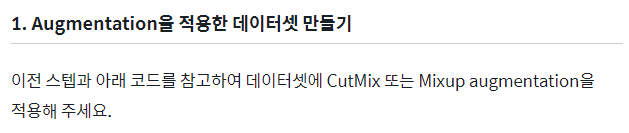

In [2]:
!mkdir -p ~/aiffel/data_augmentation/data

In [3]:
# Tensorflow and tf.keras

import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds


In [4]:
 # gpu는 대문자로 해줘야 된다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [26]:
# stanfor_dogs dataset

# tensorflow dataset에 있는 데이터
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

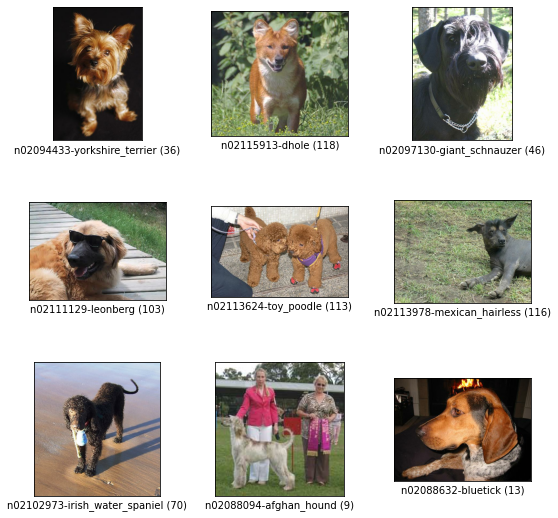

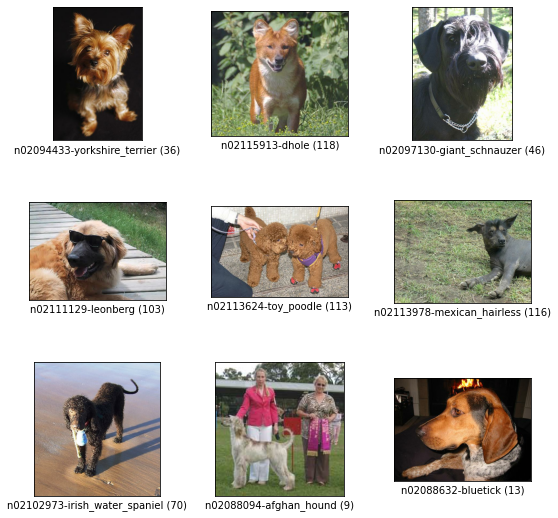

In [27]:
# 다운로드한 데이터를 확인!
tfds.show_examples(ds_train, ds_info)

In [28]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image) # 좌우 사진 flipping, up_down은 위아래 뒤집힌 사진이 없으므로 도움 x
    image = tf.image.random_brightness(image, max_delta=0.2) # 밝기 조절은 필수다. 실무에서도 무조건 사용해야하는 augmentation
    image = tf.clip_by_value(image, 0, 1) # 이 함수는 텐서 안의 값이 지정된 범위를 넘지 않게 해준다.
    return image, label

# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
    normalize_and_resize_img, # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
        augment, # augment 함수 적용
        num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)  
    return ds

**2가지 Augmentation 기법 사용하기** 

1. Cutmix Augmentation




In [29]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

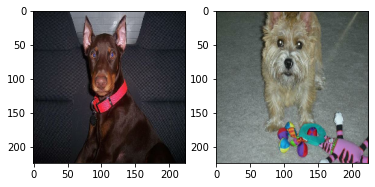

In [33]:


# 데이터셋에서 이미지 2개를 가져오기
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

이 2가지의 이미지를 얻었는데, 첫번째 개의 이미지를 a로 한다. 바탕이 되는 이미지이다. 삽입용으로는 오른쪽 개를 넣어서, a에 삽입될 영역의 바운딩 박스의 위치를 구하는 함수를 구현해 보고자 한다.

1) 이미지 섞기

In [35]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(18, shape=(), dtype=int32) tf.Tensor(176, shape=(), dtype=int32)
y :  tf.Tensor(48, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


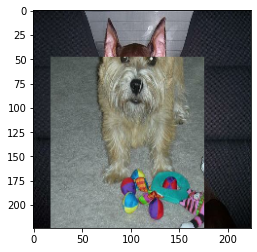

In [36]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

2) 라벨 섞기

Cutmix는 면적에 비례해서 라벨을 섞어준다. 섞인 이미지의 전체 이미지 대비 비율을 계산해서 2가지 라벨의 비율로 더해준다.

In [37]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.5542092 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [38]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

2. Mixup Augmentation

단순하게 2개의 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식이다.

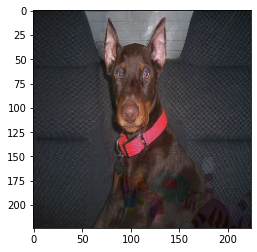

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.15206861
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.8479314  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0. 

In [40]:
# function for mixup
num_classes = ds_info.features["label"].num_classes


def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [41]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

[tensorflow one_hot encoding 함수](https://jimmy-ai.tistory.com/100)

모델을 뒤쪽에 훈련을 해야 하는데, Cutmix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는데 사용했던 sparse_categorical_cross_entropy() 대신 categorical_crossentropy()를 사용해야 한다.

cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문이다.

In [42]:
# label 변수를 만들고 원핫 인코딩 함수 만들기

def one_hot_encoding(image, label):
  label = tf.one_hot(label, num_classes)
  return image, label

In [48]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            one_hot_encoding,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

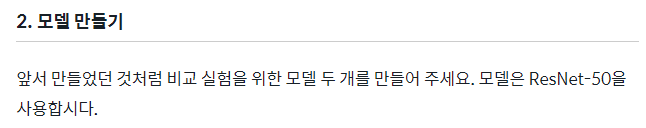

In [49]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)

Total 4가지의 모델이 필요하다.

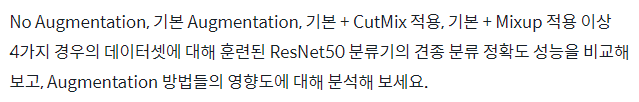

In [ ]:
# 1. No augmentation

In [50]:
no_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, # False로 했을때 fc 계층이 없음을 확인할 수 있다.
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 0s 0us/step


In [51]:
# 2. 기본 augmentation

In [52]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, # False로 했을때 fc 계층이 없음을 확인할 수 있다.
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [53]:
# 3. cutmix augmentation

In [54]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, # False로 했을때 fc 계층이 없음을 확인할 수 있다.
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [55]:
# 4. mixup augmentation

In [56]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, # False로 했을때 fc 계층이 없음을 확인할 수 있다.
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

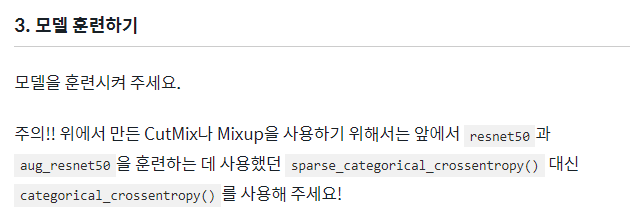

범주형 교차 엔트로피 오차 (Categorical Cross Entropy Entropy) :
범주형 교차 엔트로피 오차는 클래스가 3개 이상인 데이터를 대상으로 사용하는 손실함수이다.

One-hot 벡터 형태에서는 1 또는 0의 값이기 때문에 categorical_crossentropy를 사용한다.


In [57]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
# EPOCH = 3

# 1. no_aug
no_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
# 2. aug
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

# 3. cutmix
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
# 4. mixup
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [60]:
history_no_aug_resnet50 = no_aug_resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/20
750/750 [==============================] - 172s 205ms/step - loss: 2.2249 - accuracy: 0.4431 - val_loss: 3.2875 - val_accuracy: 0.2203
Epoch 2/20
750/750 [==============================] - 153s 204ms/step - loss: 0.6767 - accuracy: 0.8188 - val_loss: 1.1675 - val_accuracy: 0.6582
Epoch 3/20
750/750 [==============================] - 153s 204ms/step - loss: 0.1888 - accuracy: 0.9656 - val_loss: 0.9367 - val_accuracy: 0.7241
Epoch 4/20
750/750 [==============================] - 167s 223ms/step - loss: 0.0499 - accuracy: 0.9967 - val_loss: 0.9131 - val_accuracy: 0.7360
Epoch 5/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0206 - accuracy: 0.9999 - val_loss: 0.9127 - val_accuracy: 0.7408
Epoch 6/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0127 - accuracy: 1.0000 - val_loss: 0.9250 - val_accuracy: 0.7404
Epoch 7/20
750/750 [==============================] - 153s 205ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.9344 -

In [61]:
history_aug_resnet50 = aug_resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/20
750/750 [==============================] - 160s 205ms/step - loss: 2.2109 - accuracy: 0.4407 - val_loss: 3.9007 - val_accuracy: 0.1375
Epoch 2/20
750/750 [==============================] - 153s 204ms/step - loss: 0.7414 - accuracy: 0.7952 - val_loss: 1.2026 - val_accuracy: 0.6475
Epoch 3/20
750/750 [==============================] - 154s 205ms/step - loss: 0.2104 - accuracy: 0.9585 - val_loss: 0.9697 - val_accuracy: 0.7171
Epoch 4/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0525 - accuracy: 0.9966 - val_loss: 0.9168 - val_accuracy: 0.7341
Epoch 5/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0214 - accuracy: 0.9995 - val_loss: 0.9219 - val_accuracy: 0.7387
Epoch 6/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0132 - accuracy: 0.9999 - val_loss: 0.9299 - val_accuracy: 0.7380
Epoch 7/20
750/750 [==============================] - 153s 205ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.9399 -

In [62]:

history_cutmix_resnet50 = cutmix_resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/20
750/750 [==============================] - 160s 205ms/step - loss: 2.1784 - accuracy: 0.4527 - val_loss: 3.4705 - val_accuracy: 0.1865
Epoch 2/20
750/750 [==============================] - 153s 204ms/step - loss: 0.6574 - accuracy: 0.8221 - val_loss: 1.1531 - val_accuracy: 0.6599
Epoch 3/20
750/750 [==============================] - 153s 204ms/step - loss: 0.1812 - accuracy: 0.9687 - val_loss: 0.9457 - val_accuracy: 0.7267
Epoch 4/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0464 - accuracy: 0.9977 - val_loss: 0.8866 - val_accuracy: 0.7443
Epoch 5/20
750/750 [==============================] - 168s 224ms/step - loss: 0.0199 - accuracy: 0.9997 - val_loss: 0.8977 - val_accuracy: 0.7456
Epoch 6/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0156 - accuracy: 0.9998 - val_loss: 0.9311 - val_accuracy: 0.7414
Epoch 7/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0473 - accuracy: 0.9962 - val_loss: 0.9966 -

In [63]:

history_mixup_resnet50 = mixup_resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 160s 205ms/step - loss: 2.1886 - accuracy: 0.4519 - val_loss: 3.3709 - val_accuracy: 0.2134
Epoch 2/20
750/750 [==============================] - 153s 204ms/step - loss: 0.6709 - accuracy: 0.8159 - val_loss: 1.0483 - val_accuracy: 0.6909
Epoch 3/20
750/750 [==============================] - 153s 204ms/step - loss: 0.1789 - accuracy: 0.9663 - val_loss: 0.9190 - val_accuracy: 0.7263
Epoch 4/20
750/750 [==============================] - 168s 224ms/step - loss: 0.0450 - accuracy: 0.9973 - val_loss: 0.9054 - val_accuracy: 0.7389
Epoch 5/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0220 - accuracy: 0.9998 - val_loss: 0.9356 - val_accuracy: 0.7302
Epoch 6/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0357 - accuracy: 0.9975 - val_loss: 0.9494 - val_accuracy: 0.7306
Epoch 7/20
750/750 [==============================] - 167s 223ms/step - loss: 0.0133 - accuracy: 0.9997 - val_loss: 0.9471 -

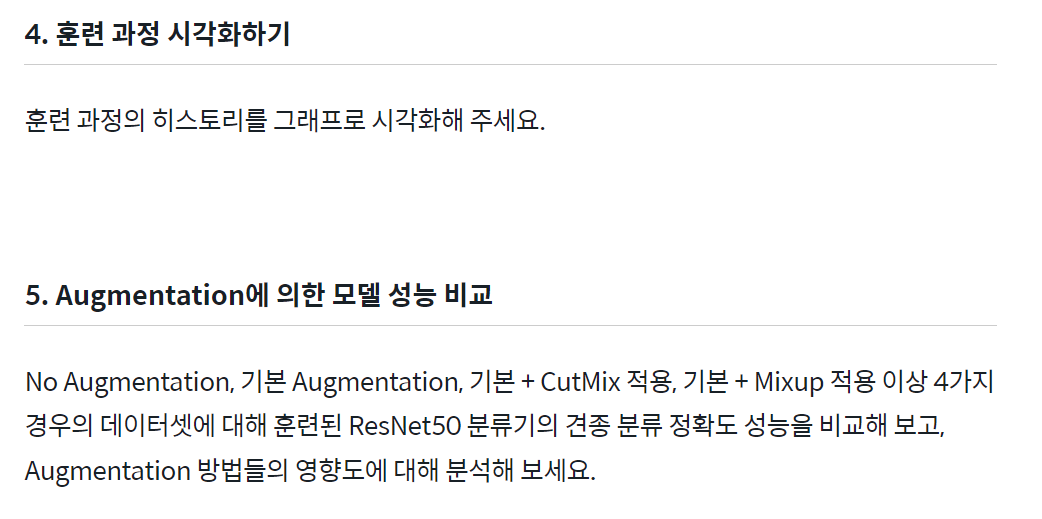

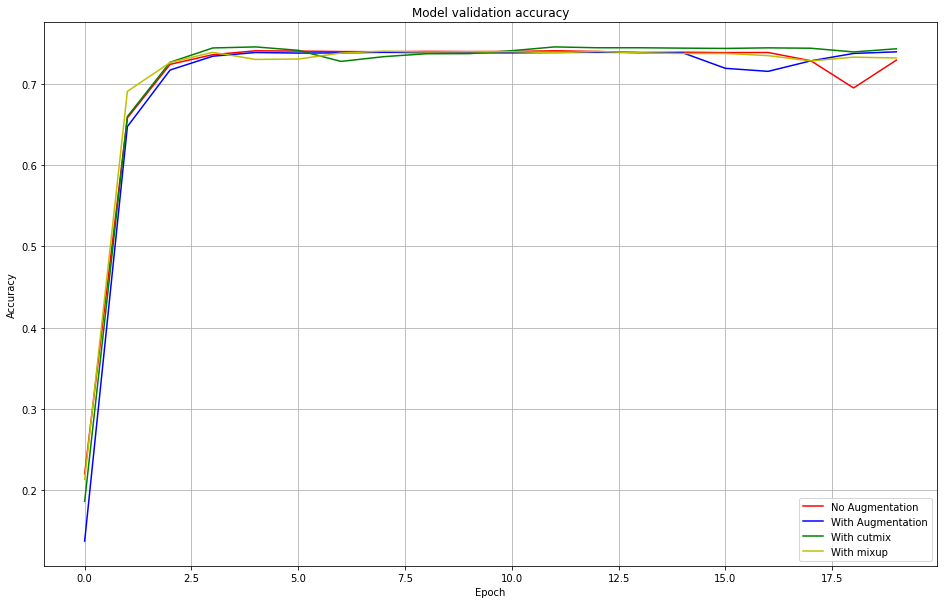

In [64]:
plt.figure(figsize=(16,10))

plt.plot(history_no_aug_resnet50.history['val_accuracy'], 'r')
plt.plot(history_aug_resnet50.history['val_accuracy'], 'b')
plt.plot(history_cutmix_resnet50 .history['val_accuracy'], 'g')
plt.plot(history_mixup_resnet50.history['val_accuracy'], 'y')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With cutmix', 'With mixup'], loc='lower right')

plt.grid(True)
plt.show()

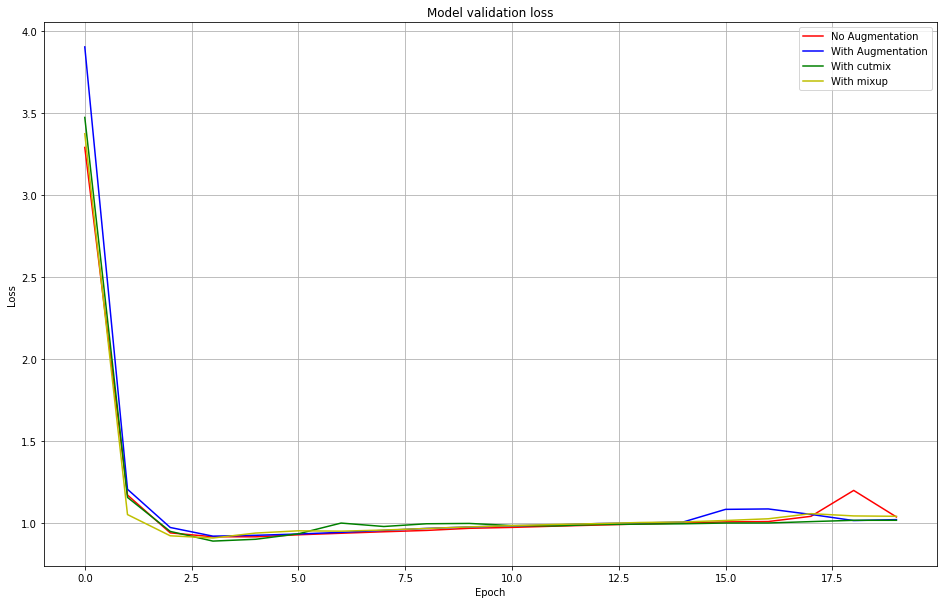

In [66]:
plt.figure(figsize=(16,10))

plt.plot(history_no_aug_resnet50.history['val_loss'], 'r')
plt.plot(history_aug_resnet50.history['val_loss'], 'b')
plt.plot(history_cutmix_resnet50 .history['val_loss'], 'g')
plt.plot(history_mixup_resnet50.history['val_loss'], 'y')

plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With cutmix', 'With mixup'], loc='upper right')

plt.grid(True)
plt.show()

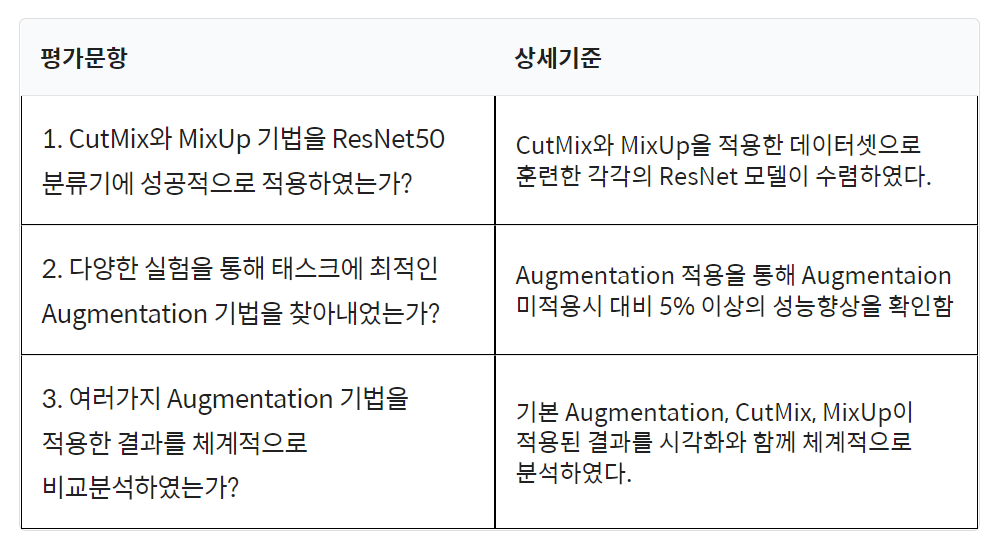

다시 해야 된다.